In [1]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from json_shot_scraper import flatten_shot, flatten_goal, flatten_complete_pass, flatten_incomplete_pass, flatten_corner
from  player_scraper import flatten_player, flatten_sub
from dataframe_cleaner import (pass_to_shot, corner_to_shot, transpose_coordinates, coord_to_yards, 
                               shot_distance_angle, dummy_columns, drop_own_goals, goal_dummy)
from model_prep import create_hypothetical_df

In [2]:
from html_scraper import db
from mongo_to_db import game_to_cleaned_df, create_frame, create_master_df, create_master_player_min_df

In [3]:
pd.set_option('display.max_columns', 50)

## Players DF

In [4]:
games = db.games.find()
players_minutes_df = create_master_player_min_df(games)

In [22]:
players_minutes_df.head()

,game_id,name,player_id,position_id,squad_number,substitute,team_id,minutes_played
0,448548,Alexander Domínguez,19132.0,1,22.0,False,20,90.0
1,448548,Lucas Hoyos,27987.0,1,12.0,True,20,0.0
2,448548,Gastón Díaz,30896.0,2,24.0,False,20,90.0
3,448548,Joaquín Laso,94225.0,2,6.0,False,20,90.0
4,448548,Luis Abram,99779.0,2,29.0,False,20,90.0


## Events DF

In [6]:
games = db.games.find()
shots_df = create_master_df(games)

/Users/david/galvanize/super_liga_xg/mongo_to_db.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  final_df = pd.concat([attach_to_df, df], axis=0, ignore_index=True)
/Users/david/galvanize/super_liga_xg/dataframe_cleaner.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  input_df['is_goal'] = input_df.loc[:, 'shot_type'].isin([9, 11, 12, 13]).astype(int)


In [59]:
shots_df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0,0,0.0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,20,26.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0,1,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0,0,0.0


## Manual Train Test Split

In [60]:
from model_prep import create_training_df, create_test_df, create_xG_df, create_summed_xG_df, create_test_min_df, merged_dataframes

In [61]:
train_data, train_y, indices, hold_test = create_training_df(shots_df)

In [62]:
test_data, test_y, indices1, holdout, test = create_test_df(shots_df, hold_test)

In [64]:
print(len(holdout))
#holdout is game_id where as the other two are shot events
print(len(train_data))
len(test_data)

49
1248


812

### RF

In [65]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier

In [66]:
random_forest_model = RandomForestClassifier(n_estimators=300, max_depth=3, verbose=1)
random_forest_model.fit(train_data, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [67]:
p_random_forest = random_forest_model.predict_proba(test_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [68]:
random_forest_ll = log_loss(test_y, p_random_forest )
random_forest_ll

0.27396254306994056

### Creating results DF

In [69]:
xg_df = create_xG_df(test_data, test_y, p_random_forest)

In [70]:
xg_df.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal,xG,xA
56,17266.0,22.564869,10.030043,0,0,0.0,0.072741,0
57,47913.0,14.644398,48.100031,1,0,0.0,0.084881,0.0848811
58,1692.0,22.843677,31.101404,1,0,0.0,0.065023,0.065023
59,44918.0,22.303410,-31.038653,0,0,0.0,0.073408,0
60,98292.0,12.733892,12.333593,1,0,0.0,0.125456,0.125456


In [71]:
contributions = create_summed_xG_df(xg_df)

In [72]:
contributions.head()

,player_id,total_xG,total_xA,total_xG+xA,goals
0,24256.0,2.49,1.58,4.07,7.0
1,16081.0,2.40,0.47,2.87,3.0
2,488.0,1.94,0.63,2.57,4.0
3,39414.0,1.73,0.70,2.43,2.0
4,150346.0,1.48,0.65,2.13,1.0


### Creating player_minutes DF to merge with

In [2]:
pm_df = create_test_min_df(players_minutes_df, test)

NameError: name 'create_test_min_df' is not defined

In [74]:
pm_df.head()

,player_id,total_minutes_played,player_name
0,46612.0,270.0,Sebastián Bértoli
1,34646.0,0.0,Federico Costa
2,29319.0,180.0,Lucas Ceballos
3,144877.0,180.0,Matías Escudero
4,16278.0,270.0,Renzo Vera


In [75]:
pm_df[pm_df['player_id'] == 101.0]

,player_id,total_minutes_played,player_name
480,101.0,270.0,Darío Cvitanich


In [76]:
final_df = merged_dataframes(pm_df, contributions)

In [77]:
final_df.head()

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Emmanuel Gigliotti,24256.0,2.49,1.58,4.07,7.0,0.758307,483.050000
1,Luis Rodríguez,16081.0,2.40,0.47,2.87,3.0,0.591391,436.766667
2,Lisandro López,488.0,1.94,0.63,2.57,4.0,0.901754,256.500000
3,Fernando Zampedri,39414.0,1.73,0.70,2.43,2.0,0.425390,514.116667
4,Pablo Alvarenga,150346.0,1.48,0.65,2.13,1.0,0.710000,270.000000


In [78]:
final_df.head()

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Emmanuel Gigliotti,24256.0,2.49,1.58,4.07,7.0,0.758307,483.050000
1,Luis Rodríguez,16081.0,2.40,0.47,2.87,3.0,0.591391,436.766667
2,Lisandro López,488.0,1.94,0.63,2.57,4.0,0.901754,256.500000
3,Fernando Zampedri,39414.0,1.73,0.70,2.43,2.0,0.425390,514.116667
4,Pablo Alvarenga,150346.0,1.48,0.65,2.13,1.0,0.710000,270.000000


# Leaders

In [79]:
final_df[(final_df['xG+xA/90'] > 0.6) & (final_df['total_minutes_played'] > 80)]

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Emmanuel Gigliotti,24256.0,2.49,1.58,4.07,7.0,0.758307,483.050000
2,Lisandro López,488.0,1.94,0.63,2.57,4.0,0.901754,256.500000
4,Pablo Alvarenga,150346.0,1.48,0.65,2.13,1.0,0.710000,270.000000
8,Cristian Chávez,30266.0,1.01,0.15,1.16,1.0,0.862216,121.083333
10,Sebastián Ribas,20195.0,0.91,0.13,1.04,1.0,0.632005,148.100000
12,Nicolás Leguizamón,172730.0,0.89,0.62,1.51,0.0,0.795978,170.733333
14,Germán Herrera,9146.0,0.88,0.43,1.31,0.0,1.081486,109.016667
22,Augusto Solari,66503.0,0.78,0.53,1.31,1.0,0.671412,175.600000
23,Facundo Barceló,98292.0,0.75,0.62,1.37,0.0,0.917638,134.366667
30,Carlos Tevez,144.0,0.70,0.46,1.16,2.0,1.143066,91.333333


In [80]:
final_df[final_df['total_xA'] > 0.5]

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Emmanuel Gigliotti,24256.0,2.49,1.58,4.07,7.0,0.758307,483.050000
2,Lisandro López,488.0,1.94,0.63,2.57,4.0,0.901754,256.500000
3,Fernando Zampedri,39414.0,1.73,0.70,2.43,2.0,0.425390,514.116667
4,Pablo Alvarenga,150346.0,1.48,0.65,2.13,1.0,0.710000,270.000000
6,Nicolás Fernández,114108.0,1.33,0.75,2.08,2.0,0.594286,315.000000
12,Nicolás Leguizamón,172730.0,0.89,0.62,1.51,0.0,0.795978,170.733333
22,Augusto Solari,66503.0,0.78,0.53,1.31,1.0,0.671412,175.600000
23,Facundo Barceló,98292.0,0.75,0.62,1.37,0.0,0.917638,134.366667
28,Matías Suárez,17135.0,0.71,0.55,1.26,0.0,0.360917,314.200000
49,Nicolás Blandi,55210.0,0.54,0.54,1.08,1.0,0.646563,150.333333


In [81]:
final_df[final_df['player_id'] == 145349.0]

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
480,Tomás Pochettino,145349.0,NaN,NaN,NaN,NaN,NaN,62.583333


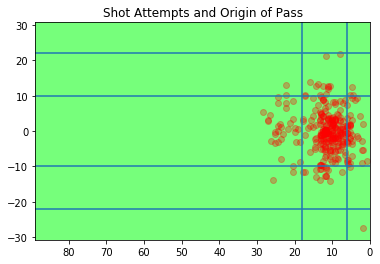

In [82]:
fig, ax = plt.subplots()
ax.scatter(shots_df[shots_df['is_goal']==1]['shot_coord_x1'], shots_df[shots_df['is_goal']==1]['shot_coord_y1'], alpha=0.3, color='red')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Shot Attempts and Origin of Pass')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

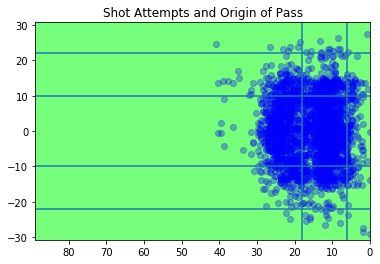

In [83]:
fig, ax = plt.subplots()
ax.scatter(shots_df['shot_coord_x1'], shots_df['shot_coord_y1'], alpha=0.3, color='blue')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Shot Attempts and Origin of Pass')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

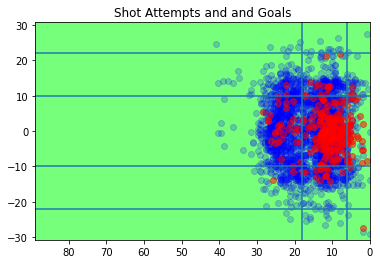

In [84]:
fig, ax = plt.subplots()
ax.scatter(shots_df[shots_df['is_goal']==0]['shot_coord_x1'], shots_df[shots_df['is_goal']==0]['shot_coord_y1'], alpha=0.2, color='blue')
ax.scatter(shots_df[shots_df['is_goal']==1]['shot_coord_x1'], shots_df[shots_df['is_goal']==1]['shot_coord_y1'], alpha=0.5, color='red')

# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Shot Attempts and and Goals')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [85]:
assisted_shots = shots_df[(shots_df['assisted_shot']==1)]
assisted_shots.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
6,448548,42505.0,11.11,1.33,11.50,4.24,-1,0.25,22336958,35,20,54.983333,177285.0,49.78,16.44,-11.50,19.67,-1.0,-1.0,0.0,15.990063,45.988197,1,0,0.0
11,448548,172756.0,14.22,0.89,13.32,-2.12,-1,0.10,22337233,35,20,85.483333,30012.0,4.89,16.00,23.61,17.86,-1.0,-1.0,0.0,19.484117,43.128255,1,0,0.0
15,448543,8907.0,11.56,0.44,-10.59,2.42,-1,0.08,22337581,9,136,10.916667,68605.0,21.78,15.11,3.03,-9.38,-1.0,-1.0,0.0,15.677426,-42.492487,1,0,1.0


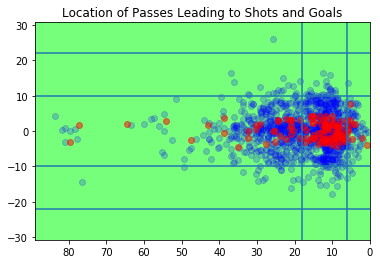

In [86]:
fig, ax = plt.subplots()
ax.scatter(assisted_shots[assisted_shots['is_goal']==0]['pass_coord_x2'], assisted_shots[assisted_shots['is_goal']==0]['shot_coord_y2'], alpha=0.2, color='blue')
ax.scatter(assisted_shots[assisted_shots['is_goal']==1]['pass_coord_x2'], assisted_shots[assisted_shots['is_goal']==1]['shot_coord_y2'], alpha=0.5, color='red')

# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('Location of Passes Leading to Shots and Goals')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

# visuals and predictions by distance per player

In [87]:
from create_shot_coordinates import shot_probability_player

In [88]:
six, eighteen, eighteen_plus, left_box, right_box = shot_probability_player(8907.0)

In [89]:
six.head()

,assisted_shot,is_penalty_attempt,shot_distance,shot_angle,player_id
0,0,0,10.198039,-78.690068,8907.0
1,0,0,8.246211,-75.963757,8907.0
2,0,0,6.324555,-71.565051,8907.0
3,0,0,4.472136,-63.434949,8907.0
4,0,0,2.828427,-45.000000,8907.0


In [90]:
six_pred = random_forest_model.predict_proba(six)
eighteen_plus = random_forest_model.predict_proba(eighteen_plus)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [91]:
from create_shot_coordinates import coord_table, distance_pred

In [92]:
random_shots = coord_table(-30, 30, 3, 18, 40, 2)

In [98]:
low_prob = distance_pred(random_shots, 145349.0)

In [103]:
low_prob.head()

,assisted_shot,is_penalty_attempt,shot_distance,shot_angle,player_id
0,0,0,34.985711,-59.036243,145349.0
1,0,0,32.449961,-56.309932,145349.0
2,0,0,30.000000,-53.130102,145349.0
3,0,0,27.658633,-49.398705,145349.0
4,0,0,25.455844,-45.000000,145349.0


In [99]:
random_prob = random_forest_model.predict_proba(low_prob)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [107]:
shots_df[shots_df['player_id'] == 145349.0]

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
235,448560,145349.0,20.89,0.00,7.26,3.33,-1,0.36,22424832,35,135,49.633333,117606.0,27.56,28.00,5.45,9.38,-1.0,-1.0,0.0,22.115599,19.164114,1,0,0.0
236,448560,145349.0,12.89,0.44,5.75,0.61,-1,1.01,22424915,34,135,54.783333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,14.114340,24.040801,0,0,0.0
559,448565,145349.0,14.67,0.89,13.92,2.72,-1,0.86,22549225,35,135,54.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20.223138,43.497307,0,0,0.0
1243,448612,145349.0,14.22,0.44,-6.66,3.63,-1,-1.00,22942797,33,135,78.366667,117606.0,57.33,57.33,11.20,11.20,-1.0,-1.0,0.0,15.702357,-25.096250,1,0,0.0
1465,448618,145349.0,17.78,9.33,-11.50,2.42,-1,0.96,23079610,34,135,19.116667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.174947,-32.894552,0,0,0.0
1468,448618,145349.0,16.89,8.00,-25.43,6.66,-1,-1.00,23081160,33,135,48.933333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.527971,-56.408835,0,0,0.0
1469,448618,145349.0,18.22,9.33,-9.08,-2.72,-1,0.76,23081426,35,135,56.666667,117606.0,31.56,34.22,-9.38,-12.71,-1.0,-1.0,0.0,20.357181,-26.489530,1,0,0.0
1824,448643,145349.0,14.22,5.78,-6.66,-2.12,-1,0.10,23318263,35,135,13.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.702357,-25.096250,0,0,0.0
1834,448643,145349.0,21.78,0.89,-7.57,-3.03,-1,-1.00,23319718,33,135,69.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,23.058042,-19.165743,0,0,0.0
2153,448658,145349.0,28.89,0.44,-1.21,-0.61,-1,-1.00,23472629,33,135,13.716667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.915328,-2.398318,0,0,0.0


In [101]:
random_prob

array([[0.25102957, 0.74897043],
       [0.24782957, 0.75217043],
       [0.23032857, 0.76967143],
       [0.22553968, 0.77446032],
       [0.22168814, 0.77831186],
       [0.22168814, 0.77831186],
       [0.20422867, 0.79577133],
       [0.20422867, 0.79577133],
       [0.20555699, 0.79444301],
       [0.20555699, 0.79444301],
       [0.20332256, 0.79667744],
       [0.21931752, 0.78068248],
       [0.21931752, 0.78068248],
       [0.2179892 , 0.7820108 ],
       [0.2179892 , 0.7820108 ],
       [0.23545425, 0.76454575],
       [0.23545425, 0.76454575],
       [0.23994986, 0.76005014],
       [0.24473875, 0.75526125],
       [0.26243852, 0.73756148],
       [0.26563852, 0.73436148],
       [0.25102957, 0.74897043],
       [0.24782957, 0.75217043],
       [0.24317794, 0.75682206],
       [0.2285619 , 0.7714381 ],
       [0.22553968, 0.77446032],
       [0.22168814, 0.77831186],
       [0.22168814, 0.77831186],
       [0.20863893, 0.79136107],
       [0.20422867, 0.79577133],
       [0.

In [100]:
low_prob.head()

,assisted_shot,is_penalty_attempt,shot_distance,shot_angle,player_id
0,0,0,34.985711,-59.036243,145349.0
1,0,0,32.449961,-56.309932,145349.0
2,0,0,30.000000,-53.130102,145349.0
3,0,0,27.658633,-49.398705,145349.0
4,0,0,25.455844,-45.000000,145349.0


In [97]:
train_data.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_penalty_attempt
0,99779.0,6.838786,12.755990,1,0
1,60730.0,21.747333,11.242763,0,0
2,177285.0,12.000000,0.000000,0,1
3,185745.0,16.803407,59.849102,1,0
4,77892.0,26.220122,32.065607,0,0


# Example of creating visual

In [322]:
print(six_pred1.sum(axis=0)[1] / len(six_pred1))
print(eighteen_pred1.sum(axis=0)[1] / len(eighteen_pred1))
print(beyond_eighteen_pred1.sum(axis=0)[1] / len(beyond_eighteen_pred1))
print(left_six_pred1.sum(axis=0)[1] / len(left_six_pred1))
print(right_six_pred1.sum(axis=0)[1] / len(right_six_pred1))

0.7955235743889505
0.8030485631465777
0.7945974953938425
0.7995026040940335
0.8023178539992006


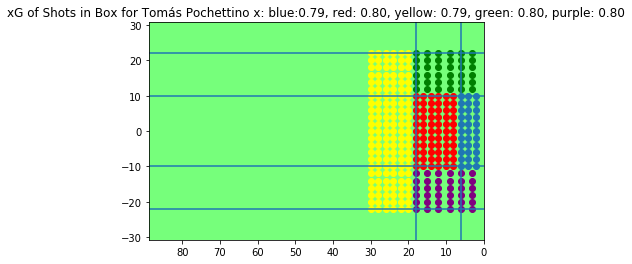

In [323]:
fig, ax = plt.subplots()
ax.scatter(six_yard_shot['shot_coord_x1'], six_yard_shot['shot_coord_y1'])
ax.scatter(eighteen_yard_shot['shot_coord_x1'], eighteen_yard_shot['shot_coord_y1'], color='red')
ax.scatter(beyond_eighteen_yard_shot['shot_coord_x1'], beyond_eighteen_yard_shot['shot_coord_y1'], color='yellow')
ax.scatter(left_six_yard_shot['shot_coord_x1'], left_six_yard_shot['shot_coord_y1'], color='green')
ax.scatter(right_six_yard_shot['shot_coord_x1'], right_six_yard_shot['shot_coord_y1'], color='purple')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of Shots in Box for Tomás Pochettino x: blue:0.79, red: 0.80, yellow: 0.79, green: 0.80, purple: 0.80')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [324]:
player2_example.head()

,assisted_shot,is_penalty_attempt,shot_distance,shot_angle,player_id
0,0,0,10.198039,-78.690068,145349.0
1,0,0,8.246211,-75.963757,145349.0
2,0,0,6.324555,-71.565051,145349.0
3,0,0,4.472136,-63.434949,145349.0
4,0,0,2.828427,-45.000000,145349.0


In [325]:
tomas_p_df = create_hypothetical_df(player2_example3, beyond_eighteen_pred1)

In [326]:
tomas_p_df.head()

,assisted_shot,is_penalty_attempt,shot_distance,shot_angle,player_id,xG
0,1,0,29.732137,-47.726311,145349.0,0.794153
1,1,0,28.284271,-45.000000,145349.0,0.792621
2,1,0,26.907248,-41.987212,145349.0,0.792621
3,1,0,25.612497,-38.659808,145349.0,0.792621
4,1,0,24.413111,-34.992020,145349.0,0.792621


In [327]:
xg_df.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal,xG,xA
39,49644.0,10.046696,-32.851730,1,0,0.0,0.228644,0.228644
40,51.0,26.782756,15.727945,0,0,0.0,0.102591,0
41,49043.0,10.122139,28.565284,0,0,0.0,0.151846,0
42,24111.0,28.617926,-46.883212,0,0,0.0,0.076079,0
43,17376.0,11.258086,-9.303354,0,0,0.0,0.148573,0
